<a href="https://colab.research.google.com/github/rahulprashar25/Melanoma-Detection/blob/main/melanoma_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing Skin Cancer Data**
#### **To do: Take necessary actions to read the data**

### **Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root = "/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration"

In [7]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(root + "/Train")
data_dir_test = pathlib.Path(root + "/Test")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total train images:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total test images:", image_count_test)
print("Total Classes:",os.listdir(data_dir_train))

Total train images: 2239
Total test images: 118
Total Classes: ['melanoma', 'nevus', 'basal cell carcinoma', 'pigmented benign keratosis', 'vascular lesion', 'squamous cell carcinoma', 'actinic keratosis', 'seborrheic keratosis', 'dermatofibroma']


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)
print("Total Training Classes:",len(class_names))


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Training Classes: 9


In [16]:
class_names_val = val_ds.class_names
print(class_names_val)
print("Total Validation Classes:",len(class_names_val))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Validation Classes: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


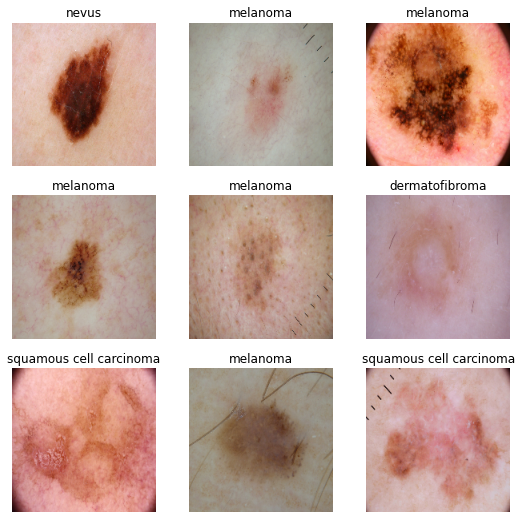

In [17]:
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(32, 180, 180, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**
#### **Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`**

In [20]:
num_class = 9

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(180,180,3)),
  layers.Conv2D(16, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_class)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Train the model**

In [23]:
epochs = 20
history = model.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

Epoch 1/20
56/56 [==============================] - 505s 2s/step - loss: 1.9252 - accuracy: 0.2863 - val_loss: 1.8586 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6578 - accuracy: 0.4040 - val_loss: 1.6577 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5984 - accuracy: 0.4420 - val_loss: 1.4876 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4403 - accuracy: 0.4972 - val_loss: 1.4284 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3677 - accuracy: 0.5201 - val_loss: 1.4815 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2757 - accuracy: 0.5575 - val_loss: 1.3948 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.1958 - accuracy: 0.5820 - val_loss: 1.3882 - val_accuracy: 0.5391
Epoch 8/20
56

### **Visualizing training results**

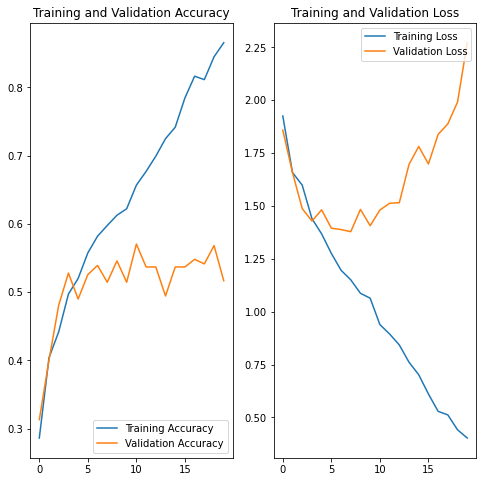

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### ***Findings***


*   Training accuracy increases but validation accuracy shows a sharp decline after 6th Epoch
*   Clearly shows that this is a case of overfitting
*   Validation Loss increases after 6th epoch

### **We need to use below techniques to treat overfitting**

* Dropouts 
* Data Augmentation 




In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


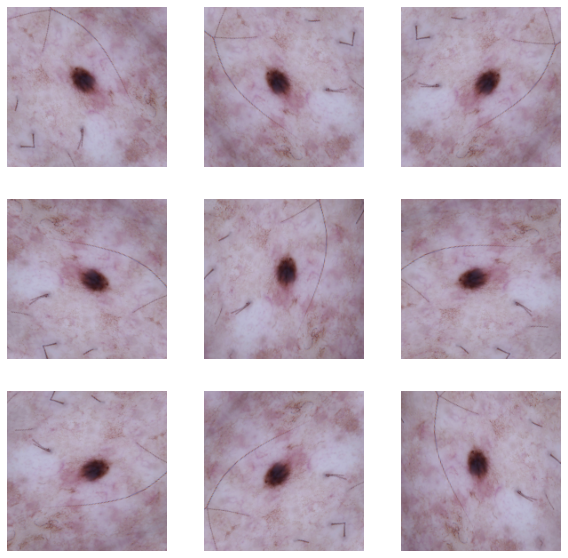

In [28]:
plt.figure(figsize = (10,10))
for images, _ in train_ds.take(5):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### **Create Model using dropouts and augmentation layers**

In [31]:
num_classes = 9

model_aug_D = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(180,180,3)),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [32]:
model_aug_D.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [33]:
model_aug_D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

In [34]:
epochs = 20
history = model_aug_D.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 1.9952 - accuracy: 0.2589 - val_loss: 1.9117 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7323 - accuracy: 0.3912 - val_loss: 1.6692 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6056 - accuracy: 0.4297 - val_loss: 1.5111 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5081 - accuracy: 0.4833 - val_loss: 1.6104 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4542 - accuracy: 0.4888 - val_loss: 1.3979 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4222 - accuracy: 0.5089 - val_loss: 1.4510 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3611 - accuracy: 0.5234 - val_loss: 1.3548 - val_accuracy: 0.5481
Epoch 8/20
56

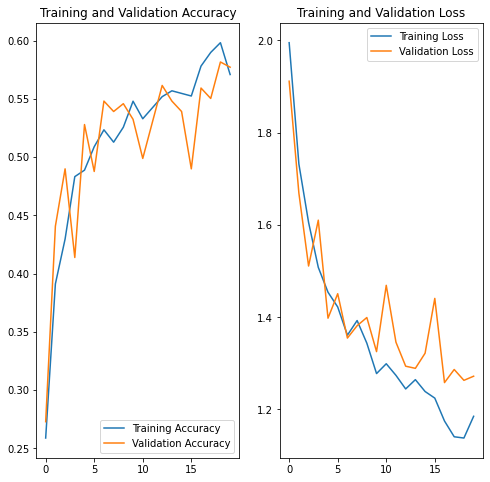

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings**

* Both training and validation accuracy are low
* Model is underfitting

One possible reason could data has high class imbalance(one class of data has high number of entries) , we can do a sanity check below


In [36]:
df = pd.DataFrame()

classes = []
train_image_number = {}
number_train_images = 0
for class_name in os.listdir(data_dir_train):
    classes.append(class_name)
    path = os.path.join(data_dir_train,class_name)
    count = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))]) 
    train_image_number[class_name] = count
    number_train_images += count

In [37]:
train_image_number

{'melanoma': 438,
 'nevus': 357,
 'basal cell carcinoma': 376,
 'pigmented benign keratosis': 462,
 'vascular lesion': 139,
 'squamous cell carcinoma': 181,
 'actinic keratosis': 114,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95}

In [39]:
print("Number of train Images:", number_train_images)

Number of train Images: 2239


In [42]:
df = pd.DataFrame(train_image_number.items(), columns = ['Class','Total'])
print(df.head())

                        Class  Total
0                    melanoma    438
1                       nevus    357
2        basal cell carcinoma    376
3  pigmented benign keratosis    462
4             vascular lesion    139


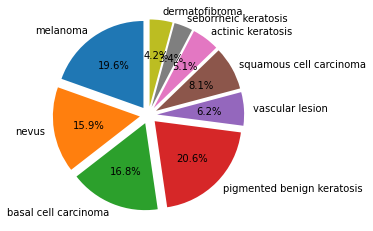

In [52]:
y = np.array(df.Total)
mylabels = df.Class
explode = [0.1]*9
plt.pie(y, labels = mylabels, explode = explode, startangle=90, autopct='%1.1f%%' )
plt.show() 



*   Data is available in large quantity for images of melanoma, nevus, basal cell carcinoma, pigmented benign keratosis
*   Data is less for all other 5 classes
* We need to use augmentor to handle this





### **Model 3: Using Augmentor**

In [105]:
#original_df

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list[:5])
lesion_list = [item.split('/')[7] for item in path_list]
print(lesion_list)


['/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000143.jpg', '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg', '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg', '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg', '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000142.jpg']
['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma'

In [106]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
1,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
2,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
3,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
4,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma


In [53]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
path_to_training_dataset="/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30765EDE90>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3070168CD0>: 100%|██████████| 500/500 [00:19<00:00, 25.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30760D8B50>: 100%|██████████| 500/500 [00:21<00:00, 23.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F30700E51D0>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F30701930D0>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30701BFD90>: 100%|██████████| 500/500 [00:19<00:00, 25.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3070193050>: 100%|██████████| 500/500 [00:44<00:00, 11.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3070102090>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F307615C090>: 100%|██████████| 500/500 [00:18<00:00, 26.34 Samples/s]


### ***Lets see the distribution of augmented data after adding new images to the original training data.***

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [62]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_e68895ac-a961-42ce-b9ee-7c6f5d278472.jpg',
 '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010766.jpg_697f3ee3-1f09-40eb-a863-b8b261a9c725.jpg',
 '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_84a13bc1-a26e-4cfd-82b1-25ed3fc0e2bf.jpg',
 '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000174.jpg_9ff399e4-564a-4cae-8a45-eb9b93371d31.jpg',
 '/content/drive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010596.jpg_caf60d91

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [65]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [112]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [111]:
new_df.head()

,Path,Label
0,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
1,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
2,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
3,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma
4,/content/drive/My Drive/Melanoma Detection/Ski...,melanoma


In [108]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

**So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.**

### **Train the model on the data created using Augmentor**


In [78]:
batch_size = 32
img_height = 180
img_width = 180

In [81]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [83]:
num_classes = 9

model_aug = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [84]:
model_aug.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [85]:
epochs = 30
history = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 183ms/step - loss: 2.2198 - accuracy: 0.1530 - val_loss: 2.0153 - val_accuracy: 0.2361
Epoch 2/30
169/169 [==============================] - 32s 181ms/step - loss: 1.8017 - accuracy: 0.2845 - val_loss: 1.6348 - val_accuracy: 0.3705
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.5478 - accuracy: 0.3880 - val_loss: 1.4730 - val_accuracy: 0.4684
Epoch 4/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4047 - accuracy: 0.4635 - val_loss: 1.4043 - val_accuracy: 0.4722
Epoch 5/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3077 - accuracy: 0.5026 - val_loss: 1.3241 - val_accuracy: 0.5167
Epoch 6/30
169/169 [==============================] - 31s 181ms/step - loss: 1.1986 - accuracy: 0.5503 - val_loss: 1.2411 - val_accuracy: 0.5739
Epoch 7/30
169/169 [==============================] - 31s 179ms/step - loss: 1.1196 - accuracy: 0.5838 - val_loss: 1.1745 - val_ac

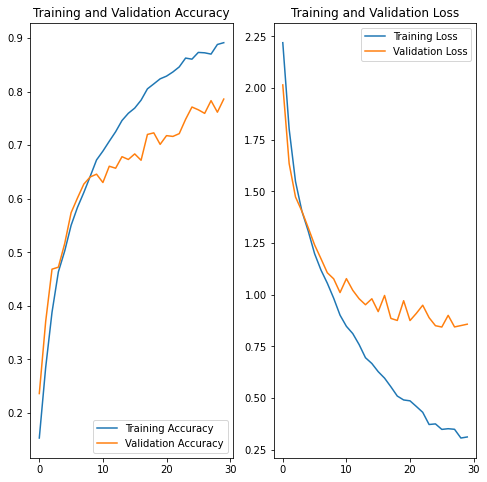

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Conclusion:**
* Final Model has a accuracy of 88% on training data, and 78% on validation data
* The model is neigther overfitting nor underfitting now
* Augmenting helped in making model stable